<a href="https://colab.research.google.com/github/yquek/Quantum-Neural-Network/blob/master/qnn_algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install cirq 
import cirq
import numpy as np
import math
import random
from cirq import Simulator
simulator = Simulator()

# A Quantum Neural Network

Our goal will be to demonstrate a quantum circuit that can learn to implement an unknown binary-valued function, $\ell(z) \in \{0,1\}$,  on an input bitstring, $z = z_1z_2\ldots z_n$. This circuit shall be called a 'quantum neural network'.

The input to our quantum neural network will be the bitstring $z$ represented as a string of qubits, i.e. $z \rightarrow |z\rangle$. In addition, there will be at the input a  'readout qubit' initially set to $|0\rangle$. 

The quantum circuit consists of some unitaries, each controlled by some subset of input qubits and acting on some subset of input qubits, with parameters $\vec{\theta}$ that the training process will tune. By tuning the parameters by gradient descent on some training examples, whose labels are given by the function the network is to learn, the network should learn that function. 

To get ONE label estimate on ONE training example, we need to run the circuit multiple times. After each run of the circuit, we make a Pauli 'Y' measurement on the readout qubit, which will return the scalar $r \in \{-1,1\}$. Finally, we average the results of multiple measurements. This constitutes the neural network's current estimate of the label $\hat{\ell}(z_\text{input})$. 

Please click on the following link for a diagram of the 
[Quantum Neural Network](https://drive.google.com/open?id=1KANnVZKGKtwQIkUG9RM6FPMCHFCkdAXM). 

We will concentrate on learning one particular function: the subset parity function. Here it will be more convenient to consider the bits as $0,1$-valued (rather than $+1,-1$ valued), using the mapping $b_i = \frac{1}{2} (1-z_i)$. Hence the input bitstring will be $b = b_1b_2\ldots b_n, \qquad b_i \in \{0,1\}$.

# Part I: The model works in principle

We will first show that, *in principle*, there exists a set of unitaries that implements any desired function $\ell(z)$, such that the above model of a neural network returns the correct result (that is, the expected value of the final Pauli measurement is always the correct output, $\ell(z)$). One may wonder if this proof will be constructive, such that we could use the set of unitaries that emerges from this analysis to design the neural network. The answer turns out to be yes; it will illustrate what sort of ansatz we should use for the set of unitaries in our neural network. 

Bear in mind that in the following analysis, we will give ourselves some advantages that aren't present when deploying the network to learn a general function; in particular we assume that we can rewire the network based on the form of the $\ell(z)$. 



---
Proof (of principle):

It will suffice for us to show that there always exists a unitary $U_{\ell}(z)$ such that when applied to the input bitstring $z$, and measured, it will always yield the correct value of $\ell_z$. Consider the unitary 

\begin{equation} 
U_{\ell} = \exp \left(i \frac{\pi}{4} \ell(z) X_{n+1}\right).
\end{equation}

Using $U_{\ell}^{\dagger} Y_{n+1} U_{\ell} = \cos(\frac{\pi}{2} \ell(z)) Y_{n+1} + \sin(\frac{\pi}{2} \ell(z)) Z_{n+1}$, we have that 

$$\langle z,0 | U^{\dagger} Y_{n+1} U |z,0 \rangle = \sin\left(\frac{\pi}{2} \ell(z)\right) = \ell(z)$$

since for our circuit $\ell(z) = \pm 1$. The L.H.S of the above equation is exactly the expectation value of the final Pauli Y-measurement in the circuit which has been applied to the initial state $|z,0 \rangle$. This means that the circuit model given in [Quantum Neural Network](https://drive.google.com/open?id=1KANnVZKGKtwQIkUG9RM6FPMCHFCkdAXM) -- with the parameters that would be specified by the exact form of $\ell(z)$ -- should implement the function $\ell(z)$ as desired.

(Note that there is a sign error in Eqn 11 in the paper; this sign error goes away if we take the expectation w.r.t. $|z,0 \rangle$ (as we have done here) instead of $|z,1 \rangle$.)

---

We will focus on the task of computing subset parity for now. The task is: given a subset of the indices $1 \ldots n$, and given a length-$n$ bitstring, what is the parity of the bits whose indices are in the subset? This is captured by the function

$\ell(z) = 1-2b(z); \qquad b(z) = \oplus a_j b_j$ where $a_i = 1$ if the $i$-th bit lies in the subset and $0$ otherwise, and $\oplus$ denotes addition modulo 2. 

Plugging this into the functional ansatz above, it becomes clear that we need to sequentially implement the unitaries $$U_{\ell}= \exp \left(i \frac{\pi}{4} X_{n+1}\right) \prod_j \exp\left(-i \frac{\pi}{2}a_j b_j X_{n+1}\right)$$ to perfectly compute this function. Here the addition is automatically modulo two. 

Now we will implement this. We first define some useful functions.

In [0]:
def choose_subset(n): 
  # choose a subset of indices out of 1,...n
  a = np.random.randint(0, high=2, size=n)
  if np.sum(a) % 2 == 0: # make sure there's an odd number of bits in the subset
    a[0]=1-a[0]
  subset = []
  for i in range(n):
    if a[i] == 1:
      subset+= [i] 
  return a,subset

def subset_parity(subset,input_b,n):
  # Compute the correct value of the subset parity function on an input ()0,1)-valued bitstring 
  s = sum(input_b[subset])
  if s % 2 == 0:
    l_z = 1.0
  else:
    l_z = -1.0
  return l_z

def hardwire_initial_state(b,qubits,n):
  for i in range(n):
    if b[i] == 1:
      yield cirq.X(qubits[i])

def measure_Y(qubit): # Make a pauli Y measurement on qubit. 
  # There's no custom function for this, so here's a hack... to measure Y, apply HS^dag then measure in computational basis
  yield cirq.ZPowGate(exponent=1.5)(qubit),cirq.H(qubit)
  
  
def compute_est(hist,num_rep,kkey):
  # Compute the value of the NN's estimate based on measurement results
  return (hist(key = kkey)[0]-hist(key = kkey)[1])/num_rep

def mod2pi(theta): 
  #display values of theta within the range [-pi,pi]
  new_theta = np.tile(0.0,len(theta))
  for i in range(len(theta)):
    a = theta[i] % (2*np.pi)
    if np.pi<a<2*np.pi:
      a = a - 2*np.pi
    new_theta[i] = a
  return new_theta

In [0]:
# Number of operational qubits (not including readout qubit)
n = 4

print('We will now see a circuit that implements the subset parity function on ', str(n), ' qubits exactly')

# Add another readout qubit
length = n+1 

# Number of times we will run the circuit to get ONE estimate for l(z) on a given input string
num_rep = 200 

# choose a subset of indices
a,subset = choose_subset(n)
print('The chosen subset consists of the following indices less than', n, ': ', subset)

# Wire up the circuit 
demo_circuit = cirq.Circuit()

# The input is a bitstring b
b = np.random.randint(0, high=2, size=n)
print('The input bitstring is ', b)

# Compute the correct value of the subset parity function
l_z = subset_parity(subset,b,n)
print('The correct label, or value of subset parity, on this example, is', l_z)

# hardwire the initial state. We will not be using an auxiliary qubit in this computation, so the last (nth) qubit is the readout qubit. 
qubits = [cirq.GridQubit(i,0) for i in range(length-1)]
readout = cirq.GridQubit(length-1, 0)
demo_circuit.append([hardwire_initial_state(b,qubits,n)])
demo_circuit.append([cirq.Rx(-np.pi/2)(readout)])

# Now add controlled rotations
for i in range(n):
  cX = cirq.ControlledGate(cirq.Rx(-np.pi*a[i]))
  demo_circuit.append([cX(qubits[i],readout)])

# Put in the Y measurement. 
demo_circuit.append([measure_Y(readout),cirq.measure(readout, key='demo')])
print('The circuit that computes subset parity *exactly* is')
print(demo_circuit)

# Let's run this circuit
demo_results = simulator.run(demo_circuit,repetitions=num_rep)
estimate = compute_est(demo_results.histogram,num_rep,'demo')
print('Computed value of function: ', estimate)

We will now see a circuit that implements the subset parity function on  4  qubits exactly
The chosen subset consists of the following indices less than 4 :  [0, 1, 3]
The input bitstring is  [1 0 1 1]
The correct label, or value of subset parity, on this example, is 1.0
The circuit that computes subset parity *exactly* is
(0, 0): ───X───────────────@─────────────────────────────────────────────────────────────
                           │
(1, 0): ───────────────────┼────────@────────────────────────────────────────────────────
                           │        │
(2, 0): ───X───────────────┼────────┼────────@───────────────────────────────────────────
                           │        │        │
(3, 0): ───X───────────────┼────────┼────────┼───────────@───────────────────────────────
                           │        │        │           │
(4, 0): ───────Rx(-0.5π)───Rx(-π)───Rx(-π)───Rx(-0.0π)───Rx(-π)───S^-1───H───M('demo')───
Computed value of function:  1.0


# Part II: Learning

Now we will make a quantum neural network that learns the optimal values of the parameters for the subset parity problem.   

Our ansatz will be the following unitary with $n$ parameters $\vec{\theta} = (\theta_1, \ldots \theta_n)$:

$$U(\vec{\theta}) = \exp \left(i \frac{\pi}{4} X_{n+1}\right) \exp\left(-i \sum_j \theta_j b_j X_{n+1}\right)$$

Note that the second term here, $\exp\left(-i \sum_j \theta_j b_j X_{n+1}\right)$, depends on the value of the bits $b_i$. This can be implemented as a concatenation of controlled unitaries of the form $\exp\left(-i \theta_j b_j X_{n+1}\right)$, controlled by the $j$-th bit and acting on the $n+1$-st, or readout, qubit. Recalling that the label function to be learned is $\ell(z) = 1-2b(z); \qquad b(z) = \oplus a_j b_j$, we may observe that this ansatz is pretty much in the same form as the optimal unitary $U_{\ell}$ in the previous section. Indeed, setting $\theta_i = \frac{\pi}{2} a_i$, we recover the previous 'ideal' circuit. That is,

**The optimal value of the parameters is $\theta_i = \frac{\pi}{2}$ for $i$ included in the subset, and $\theta_i = 0$ otherwise.**

--- 

## Computing the derivative of the loss

The loss function we are using is $$1-\ell(z) \langle z,1 | U^{\dagger}(\vec{\theta}) Y_{n+1} U(\vec{\theta}) |z,1 \rangle $$ where $\langle z,1 | U^{\dagger}(\vec{\theta}) Y_{n+1} U(\vec{\theta}) |z,1 \rangle$ is the value of the neural network's current estimate bounded between $-1$ and $1$. Hence, if the neural network is giving the correct estimate, its loss should be zero which is also the minimum value of the loss; the maximum is two. 

In order to backpropagate, we need to estimate the derivative of the loss against the relevant parameter. The paper suggested two methods to do so; the first involves a finite-difference estimate of the gradient; and the second is semi-analytic, deriving an expression for the gradient in terms of an expected value of some function of the circuit unitaries (incidentally, their expression is missing some terms...), and then running the circuit to evaluate this expected value.

We go a step further and derive a fully analytic expression for the gradient of the loss function, which we then compute and use immediately in backpropagation. 

## Method #1: Fully Analytic

$$Loss(\vec{\theta},z) = 1-\ell(z) \langle z,0 | U^{\dagger}(\vec{\theta}) Y_{n+1} U(\vec{\theta}) |z,0 \rangle $$

For our subset parity ansatz, $$U(\vec{\theta}) = \exp \left(i \frac{\pi}{4} X_{n+1}\right) \exp\left(-i \sum_{j=1}^L \theta_j b_j X_{n+1}\right) = e^{i \frac{\pi}{4}X} \prod_{j=1}^L U^{(j)}$$

where $ U^{(j)} \triangleq \exp\left(-i \theta_j b_j X_{n+1}\right)$ and the vector of parameters to be adjusted is $\vec{\theta} = (\theta_1, \ldots \theta_L)$.

\begin{equation}
\begin{split}
\frac{\partial{Loss(\vec{\theta},z)}}{\partial{\theta_k}} & = -\ell(z) \left[ \langle z,0 | e^{-i \frac{\pi}{4}X} U^{(1)\dagger} \ldots \left(i  b_k X U^{(k)\dagger}\right) \ldots U^{(L)\dagger} Y U^{(L)} \ldots U^{(1)} e^{i \frac{\pi}{4}X}  |z,0 \rangle \\ 
+ \langle z,0 | e^{-i \frac{\pi}{4}X} U^{(1)\dagger}\ldots U^{(k)\dagger} YU^{(L)} \ldots \left(-i  b_k X U^{(k)} \right) \ldots U^{(1)} e^{i \frac{\pi}{4}X} |z,0 \rangle \right] 
\end{split}
\end{equation}

where all $X, Y$ are Pauli operators acting on the $(n+1)-th$ (readout) qubit. 

Defining $\tilde{U}(\vec{\theta}) = e^{-i \frac{\pi}{4}X} U^{(1)\dagger}\ldots U^{(k)\dagger} YX U^{(L)} \ldots U^{(1)} e^{i \frac{\pi}{4}X}$ (note here the $X $ is on the right of the $Y$) we may re-write the above equation:

\begin{equation} 
\begin{split}
\frac{\partial{Loss(\vec{\theta},z)}}{\partial{\theta_k}} &= \left(-i b_k \ell(z) \right) \left[ \langle z,0 |\tilde{U}(\vec{\theta})  |z,0 \rangle^{\dagger} - \langle z,0 |\tilde{U}(\vec{\theta})  |z,0 \rangle \right]\\
&= - 2 \ell(z) b_k Im(\langle z,0 |\tilde{U}(\vec{\theta})  |z,0 \rangle)
\end{split}
\end{equation}

Going beyond the paper, we are able to calculate this exactly. In analogy to our previous definition, we may now define 
$$U_{\hat{\ell}} = \exp \left(i \frac{\pi}{4} X_{n+1}\right) \prod_j \exp\left(-i \theta_j b_j X_{n+1}\right) $$ where the equivalent `label function' on untuned parameters is now $\hat{\ell}(z) \triangleq \frac{1-\vec{\theta}\cdot \vec{b}}{\pi/4}$. After some algebra,

$\tilde{U}(\vec{\theta}) = U_{\hat{\ell}}(\vec{\theta})Y_{n+1} X_{n+1} U_{\hat{\ell}}(\vec{\theta}) = i \left(-\cos(\frac{\pi}{2} {\hat{\ell}(z)}) Z_{n+1} + \sin(\frac{\pi}{2} {\hat{\ell}(z)}) Y_{n+1} \right)$

and therefore 
\begin{equation}
\begin{split}
\frac{\partial{Loss(\vec{\theta},z)}}{\partial{\theta_k}}  &= - 2 \ell(z) b_k Im(\langle z,0 |\tilde{U}(\vec{\theta})  |z,0 \rangle) \\
& = 2\ell(z) b_k \cos \left(\frac{\pi}{2} {\hat{\ell}}(z)\right) 
\end{split}
\end{equation}


Here $\ell(z)$ retains its meaning as the label function we want to compute, $\ell(z) = 1-2\oplus a_j b_j$ where $\oplus$ denotes bitwise addition. $\hat{\ell}(z)$ is to be interpreted as the function that the neural network is implementing with its yet-to-be-optimized parameters. 

In [0]:
# First we refactor the above code for running the neural network on each input string, and add code for partitioning examples into train examples and test examples. 

def one_input(b, theta, kkey, n):  
  # wire up the circuit for a single input. The circuit depends on the input because I am literally applying X's to initialize bits to |1> (by default all bits are initialized to |0>)
  
  # hardwire the initial state
  qubits = [cirq.GridQubit(i,0) for i in range(length-1)]
  readout = cirq.GridQubit(length-1, 0)
  yield hardwire_initial_state(b,qubits,n)
  yield cirq.Rx(-np.pi/2)(readout)
  
  # Now add controlled rotations, one for every qubit in the input with the parameter theta_j
  for i in range(n):
    cX = cirq.ControlledGate(cirq.Rx(2*theta[i]))
    yield cX(qubits[i],readout)

  # Put in the Y measurement. 
  yield measure_Y(readout)
  yield cirq.measure(readout, key = kkey)

def generate_examples(n):
  # Generate an instance of the problem: generate the subset, and the labelled examples (both train and test sets)
  
  # Choose the subset
  a,subset = choose_subset(n)

  # Initialize all possible inputs. These will be divided into test and training examples respectively. 
  all_states = [[int(j) for j in list(np.binary_repr(i,width = n))] for i in np.arange(2**n)]
  random.shuffle(all_states)
  num_test = int(math.floor(len(all_states)/5.0)) #80/20 train/test split (since we're talking small numbers of qubits here)
  num_train = len(all_states)-num_test
  
  test_examples = []
  test_labels = []
  for i in range(num_test):
    test_examples.extend([all_states[i]])
    bb = np.array(all_states[i])
    test_labels.extend([subset_parity(subset,bb,n)])
    
  train_examples = []
  train_labels = []
  for i in range(num_train):
    bb = np.array(all_states[i+num_test])
    train_examples.extend([all_states[i+num_test]])
  train_examples = np.tile(train_examples,(5,1)) 
  random.shuffle(train_examples)
  for i in range(len(train_examples)):
    bb = np.array(train_examples[i])
    train_labels.extend([subset_parity(subset,bb,n)])
    
  return subset, train_examples, train_labels, test_examples, test_labels


# Define a function that uses our fully analytic expression to exactly computes the gradient of the loss
def exact_grad_subsetparity(bb, l_z, theta):
  dloss = np.zeros(len(bb))
  for i in range(len(bb)):
    bk = bb[i]
    if bk == 1:
      lhat = 1-np.dot(theta,bb)/(np.pi/4) 
      dloss[i] = 2*l_z*np.cos(np.pi/2* lhat)
  return dloss

Comment: Ideally I would not have to re-wire up the circuit with new parameters every time I changed the parameters, but rather, be able to pass in changed values of parameters to some symbolic placeholder. Actually, there is already such a function in Cirq called param_resolver, BUT THERE IS A BUG in its implementation of symbolic linear algebra. This bug comes up even when I run the Cirq tutorial code as-is, whether in Python 2 or Python 3. Therefore I am doing the naive thing as you can see below. 

In [0]:
# Train

np.random.seed(0)

# Set the fixed params
r = 0.2 # learning rate
n = 5 #  number of qubits apart from the readout qubit
length = n+1 # number of input qubits to the neural network (+1 is for the readout qubit)
numrep = 1000

# Randomly initialize the parameters, theta
randvec = np.random.uniform(low=0.0, high=1.0, size=n)
theta = mod2pi(2*np.pi*randvec)

# Generate an instance of the problem
subset, train_examples, train_labels, test_examples, test_labels = generate_examples(n) 
print('The chosen subset consists of the following indices less than', n, ': ', subset)

store_loss = np.zeros(len(train_examples))
store_theta = np.zeros((len(train_examples),n))

for ii,b in enumerate(train_examples):
  
  bb = np.array(b)
  l_z = train_labels[ii]
  
  # Wire up the circuit
  main_circuit = cirq.Circuit()
  kkey = 'main'
  main_circuit.append(one_input(bb,theta,kkey,n))

  # Let's run this circuit
  main_results = simulator.run(main_circuit,repetitions=numrep)
  loss = 1.0-l_z*compute_est(main_results.histogram, numrep, kkey)
  store_loss[ii] = loss
  
  dloss = exact_grad_subsetparity(bb, l_z, theta)
  # Update the parameters theta
  
  if sum(np.abs(dloss)) > 1e-8:
    theta = theta - r*loss/(np.linalg.norm(dloss,2)**2)*dloss
    theta = mod2pi(theta)
  else:
    theta = theta  
    
  store_theta[ii,:] = theta

The chosen subset consists of the following indices less than 5 :  [3]


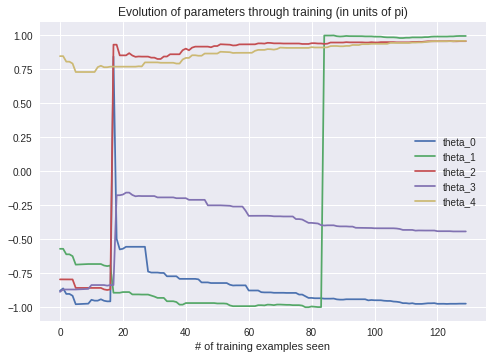

In [0]:
from matplotlib import pyplot as plt

x = np.arange(len(train_examples))
for i in range(n):
  plt.plot(x,store_theta[:,i]/np.pi,label='theta_'+str(i))
plt.plot()
plt.legend()
plt.xlabel('# of training examples seen')
plt.title('Evolution of parameters through training (in units of pi)')
plt.show()

## Remarks

Please set the random seed to 0 and choose the following parameters: $r = 0.2,  n = 5, length = n+1, numrep = 1000$ to see the following effects. 

(If there are large jumps in the graph from $\pi$ to $-\pi$, they are an artefact of the fact that we have restricted the angles to lie in the range $(-\pi, \pi)$, such that $\pi+\epsilon$ is stored as $-\pi+\epsilon$)

Earlier, we wrote that one possible solution that always implements the function perfectly is  **$\theta_i = \frac{\pi}{2}$ for $i$ included in the subset, and $\theta_i = 0$ otherwise.**

We see that the neural network has found an alternative solution: $\theta_i = \frac{-\pi}{2}$ for $i$ in the subset (here $i = 3$) and $\theta_i = \pi = - \pi$ otherwise. (If the above graph doesn't show these alternative solutions, run the circuit a few more times...) This is at first puzzling, as our Ansatz (i.e. the function implemented by the circuit) was 

$$U(\vec{\theta}) = \exp\left(i \frac{\pi}{4} X_{n+1}\right) \prod_j \exp(-i \theta_j b_j X_{n+1})$$

and it seems that shifting our 'optimal' solution by multiples of $\pi$, as we have done here, might yield some undesirable minus signs. 

However, we discovered that we can analytically work out the value of the loss even with possibly non-optimal parameters: We remind the reader of the definition of the loss
$$Loss(\vec{\theta},z) \triangleq 1-\ell(z) \langle z,0 | U^{\dagger}(\vec{\theta}) Y_{n+1} U(\vec{\theta}) |z,0 \rangle. $$ It turns out that
$$ \langle z,0 | U^{\dagger}(\vec{\theta}) Y_{n+1} U(\vec{\theta}) |z,0 \rangle = \sin\left(\frac{\pi}{2} \left(1- \frac{\vec{\theta} \cdot \vec{b}}{\pi/4} \right)\right)$$. 

Since $\vec{b}$ is a binary-valued function, the above re-writing makes it explicit that shifting our parameters by a multiple of $\pi$ also shifts the argument of the $\sin$ by a multiple of $2\pi$, which makes no difference overall. With the above re-writing, we can therefore also characterize all optimal parameters of the function: 

**$\theta_i = \frac{(1+2k)\pi}{2}$ for $i$ included in the subset, and $\theta_i = k \pi$ otherwise, $k \in \mathbb{Z}$.**

Going back to our neural network, finally we evaluate our parameters on the test set. With 5 qubits there are only 32 possible input strings and with a 20/80 test/training split, only 6 examples in the test set. But one can also play around with parameters and increase the number of qubits to get more test set examples. 

In [0]:
# test

all_loss = np.zeros(len(test_examples))

for ii,b in enumerate(test_examples):
  bb = np.array(b)
  l_z = test_labels[ii]
  
  # Wire up the circuit
  main_circuit = cirq.Circuit()
  kkey = 'loss'
  main_circuit.append(one_input(bb,theta,kkey,n))

  # Let's run this circuit
  main_results = simulator.run(main_circuit,repetitions=numrep)
  loss = 1.0-l_z*compute_est(main_results.histogram, numrep, kkey)
  all_loss[ii] = loss
  
av_loss = np.mean(all_loss)
print('Average loss on test examples', av_loss)

Average loss on test examples 0.026333333333333358


## Method #2: Approximation
The paper recommended another way of estimating the derivative of the loss when one cannot compute it directly: implement the following approximation: 

$$ \frac{df}{dx}(x) = (f(x+\epsilon) - f(x-\epsilon))/(2*\epsilon) + O(\epsilon^2) $$

The paper also says 'To estimate loss to order $\epsilon^3$ we need of order $1/\epsilon^6$ measurements'. Let's try this method, and see if we can get away with less. 

In [0]:
def approx_gradient(b, eps, l_z, theta, numrep_2):
  # estimate the gradient of the loss 
  dloss = np.zeros(len(theta))
  for i in range(len(theta)):
    #  print('Now examining the', i, 'th component of the loss')
      e_i = np.zeros(len(theta))
      e_i[i] = eps
      shifted_theta_1 = theta+e_i

      circuit_1 = cirq.Circuit()
      kkey = 'one'
      circuit_1.append(one_input(b,shifted_theta_1,kkey,n))
      circuit_1_results = simulator.run(circuit_1,repetitions=numrep_2)
      est_1 = compute_est(circuit_1_results.histogram, numrep_2, kkey)
      loss_1 = 1.0-l_z*est_1

      shifted_theta_2 = theta-e_i
      circuit_2 = cirq.Circuit()
      kkey = 'two'
      circuit_2.append(one_input(b,shifted_theta_2,kkey,n))
      circuit_2_results = simulator.run(circuit_2,repetitions=numrep_2)
      est_2 = compute_est(circuit_2_results.histogram, numrep_2,kkey)
      loss_2 = 1.0-l_z*est_2

      dloss[i] = (loss_1 - loss_2)/(2*eps) 
    
  return dloss

The chosen subset consists of the following indices less than 5 :  [0, 1, 4]


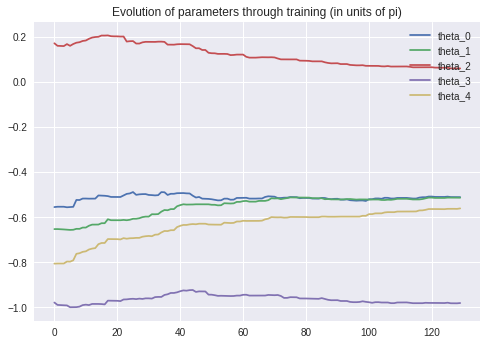

In [0]:
# Train


# Set the fixed params
r = 0.2 # learning rate
n = 5 #  number of qubits apart from the readout qubit
length = n+1 # number of input qubits to the neural network (+1 is for the readout qubit)
eps = 1e-1
numrep = 1000
numrep_2 = 1000

# Randomly initialize the parameters, theta
randvec = np.random.uniform(low=0.0, high=1.0, size=n)
theta = mod2pi(2*np.pi*randvec)

# Generate an instance of the problem
subset, train_examples, train_labels, test_examples, test_labels = generate_examples(n) 
print('The chosen subset consists of the following indices less than', n, ': ', subset)

store_loss = np.zeros(len(train_examples))
store_theta = np.zeros((len(train_examples),n))

for ii,b in enumerate(train_examples):
  
  bb = np.array(b)
  l_z = train_labels[ii]
  
  # Wire up the circuit
  main_circuit = cirq.Circuit()
  kkey = 'main'
  main_circuit.append(one_input(bb,theta,kkey,n))

  # Let's run this circuit
  main_results = simulator.run(main_circuit,repetitions=numrep)
  loss = 1.0-l_z*compute_est(main_results.histogram, numrep, kkey)
  store_loss[ii] = loss
  
  # Compute the gradient of the loss
  dloss = approx_gradient(b,eps,l_z,theta,numrep_2)
  
  # Update the parameters theta
  
  if sum(np.abs(dloss)) > 1e-8:
    theta = theta - r*loss/(np.linalg.norm(dloss,2)**2)*dloss
    theta = mod2pi(theta)
  else:
    theta = theta  
    
  store_theta[ii,:] = theta
  
x = np.arange(len(train_examples))
for i in range(n):
  plt.plot(x,store_theta[:,i]/np.pi,label='theta_'+str(i))
plt.plot()
plt.legend()
plt.xlabel('# of training examples seen')
plt.title('Evolution of parameters through training (in units of pi)')
plt.show()

In [0]:
# test

all_loss = np.zeros(len(test_examples))

for ii,b in enumerate(test_examples):
  bb = np.array(b)
  l_z = test_labels[ii]
  
  # Wire up the circuit
  main_circuit = cirq.Circuit()
  kkey = 'loss'
  main_circuit.append(one_input(bb,theta,kkey,n))

  # Let's run this circuit
  main_results = simulator.run(main_circuit,repetitions=numrep)
  loss = 1.0-l_z*compute_est(main_results.histogram, numrep, kkey)
  all_loss[ii] = loss
  
av_loss = np.mean(all_loss)
print('Average loss on test examples', av_loss)

Average loss on test examples 0.159


Clearly this method of approximating the gradient also works, but at a cost in terms of circuit evaluations:

**Number of circuit evaluations**

**Method 1 (fully analytic derivation of loss gradient):**  `num_training_examples` 

**Method 2 (from paper) (approximate the loss gradient): ** (2 $\times$ `num_rep_2` $\times$+1) `num_training_examples` 

Method 2 also seems to produce smoother evolutions of the parameters, but I'm not sure why. There is another method proposed in the paper which is to derive a semi-analytic expression for the loss gradient and then estimate it by running the circuit, but as we already had an expression for loss gradient, we didn't test this. 

## Optimization of learning rate

Finally, we optimize the hyperparameter 'r'. We use Method #1 for this as it is much faster. Here we will also be using a validation set to optimize the hyperparameter on. 

In [0]:
def generate_examples_w_validation(n):
  # Generate an instance of the problem: generate the subset, and the labelled examples (train,test,validation sets)
  
  # Choose the subset
  a,subset = choose_subset(n)

  # Initialize all possible inputs. These will be divided into test and training examples respectively. 
  all_states = [[int(j) for j in list(np.binary_repr(i,width = n))] for i in np.arange(2**n)]
  random.shuffle(all_states)
  num_test = int(math.floor(len(all_states)/10.0)) #80/10/10 train/validation/test split 
  num_validation = int(math.floor(len(all_states)/10.0)) #80/10/10 train/validation/test split 
  num_train = len(all_states)-num_test-num_validation
  
  validation_examples = []
  validation_labels = []
  for i in range(num_validation):
    validation_examples.extend([all_states[i]])
    bb = np.array(all_states[i])
    validation_labels.extend([subset_parity(subset,bb,n)])
    
  test_examples = []
  test_labels = []
  for i in range(num_test):
    test_examples.extend([all_states[i+num_validation]])
    bb = np.array(all_states[i+num_validation])
    test_labels.extend([subset_parity(subset,bb,n)])
    
  train_examples = []
  train_labels = []
  for i in range(num_train):
    bb = np.array(all_states[i+num_test+num_validation])
    train_examples.extend([all_states[i+num_test+num_validation]])
  train_examples = np.tile(train_examples,(3,1)) 
  random.shuffle(train_examples)
  for i in range(len(train_examples)):
    bb = np.array(train_examples[i])
    train_labels.extend([subset_parity(subset,bb,n)])
    
  return subset, train_examples, train_labels, test_examples, test_labels, validation_examples, validation_labels

In [0]:
r_list = np.exp(np.linspace(-5,0,10))
v_loss = np.zeros(len(r_list))
store_theta = np.zeros((len(r_list),n))
                
n = 8 #  number of qubits apart from the readout qubit
length = n+1 # number of input qubits to the neural network (+1 is for the readout qubit)
numrep = 1000

# Randomly initialize the parameters, theta
randvec = np.random.uniform(low=0.0, high=1.0, size=n)
theta = mod2pi(2*np.pi*randvec)

# Generate an instance of the problem
subset, train_examples, train_labels, test_examples, test_labels, v_examples, v_labels = generate_examples_w_validation(n) 
print('The chosen subset consists of the following indices less than', n, ': ', subset)

for j,r in enumerate(r_list):
  # Train
  for ii,b in enumerate(train_examples):

    bb = np.array(b)
    l_z = train_labels[ii]

    # Wire up the circuit
    main_circuit = cirq.Circuit()
    kkey = 'main'
    main_circuit.append(one_input(bb,theta,kkey,n))

    # Let's run this circuit
    main_results = simulator.run(main_circuit,repetitions=numrep)
    loss = 1.0-l_z*compute_est(main_results.histogram, numrep, kkey)

    dloss = exact_grad_subsetparity(bb, l_z, theta)
    # Update the parameters theta

    if sum(np.abs(dloss)) > 1e-8:
      theta = theta - r*loss/(np.linalg.norm(dloss,2)**2)*dloss
      theta = mod2pi(theta)
    else:
      theta = theta  

  store_theta[j,:] = theta
    
  # Look at performance on validation set
  all_loss = np.zeros(len(v_examples))

  for ii,b in enumerate(v_examples):
    bb = np.array(b)
    l_z = v_labels[ii]

    # Wire up the circuit
    main_circuit = cirq.Circuit()
    kkey = 'validate'
    main_circuit.append(one_input(bb,theta,kkey,n))

    # Let's run this circuit
    main_results = simulator.run(main_circuit,repetitions=numrep)
    loss = 1.0-l_z*compute_est(main_results.histogram, numrep, kkey)
    all_loss[ii] = loss

  v_loss[j] = np.mean(all_loss)
  
val, idx = min((val, idx) for (idx, val) in enumerate(v_loss))
print('The value of r that performed best on the validation set is',r_list[idx], 'achieving a loss of', val)

The chosen subset consists of the following indices less than 8 :  [0, 2, 3, 4, 5, 6, 7]
0.32919298780790573
The value of r that performed best on the validation set is None achieving a loss of 0.0


In [0]:
# Run on test set

r_best = r_list[idx]
theta = store_theta[idx,:]

all_loss = np.zeros(len(test_examples))

for ii,b in enumerate(test_examples):
  bb = np.array(b)
  l_z = test_labels[ii]
  
  # Wire up the circuit
  main_circuit = cirq.Circuit()
  kkey = 'loss'
  main_circuit.append(one_input(bb,theta,kkey,n))

  # Let's run this circuit
  main_results = simulator.run(main_circuit,repetitions=numrep)
  loss = 1.0-l_z*compute_est(main_results.histogram, numrep, kkey)
  all_loss[ii] = loss
  
av_loss = np.mean(all_loss)
print('Average loss on test examples', av_loss)

Average loss on test examples 0.0


With this hyperparameter choice, we have computed the subset parity function perfectly!